## Setup libraries

In [2]:
from fastai.vision.all import *

## Get data

In [3]:
path = Path('/media/veracrypt1/Data Science/SIIM-Imgs/png')
stage = 'train'

df = pd.read_pickle('src/train_ready.pkl')

Remove image file extension

In [4]:
df['id'] = df['id'].apply(lambda x: x[:-4])

In [5]:
df.head()

,id,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,boxes_list,labels_list,label,resized_boxes,scalar
0,000a312787f2,5776db0cec75,0,1,0,0,"[[789.28836, 582.43035, 1815.94498, 2499.73327], [2245.91208, 591.20528, 3340.5737, 2352.75472]]","[Typical, Typical]",Typical,"[[189.904, 140.134, 436.919, 601.44], [540.37, 142.245, 803.747, 566.076]]",0.240602
1,000c3a3f293f,ff0879eb20ed,1,0,0,0,"[[0.0, 0.0, 1.0, 1.0]]",[Negative],Negative,"[[0.0, 0.0, 1.0, 1.0]]",NaN
2,0012ff7358bc,9d514ce429a7,0,1,0,0,"[[677.42216, 197.97662, 1545.21983, 1197.75876], [1792.69064, 402.5525, 2409.71798, 1606.9105]]","[Typical, Typical]",Typical,"[[226.99, 66.338, 517.77, 401.343], [600.692, 134.887, 807.445, 538.441]]",0.335079
3,001398f4ff4f,28dddc8559b2,0,0,0,1,"[[2729.0, 2181.33331, 3677.00012, 2785.33331]]",[Atypical],Atypical,"[[652.92, 521.889, 879.731, 666.398]]",0.239252
4,001bd15d1891,dfd9fdd85a3e,0,1,0,0,"[[623.23328, 1050.0, 1337.23328, 2156.0], [2578.56661, 998.66667, 3241.23328, 2118.66667]]","[Typical, Typical]",Typical,"[[187.263, 315.493, 401.798, 647.812], [774.781, 300.069, 973.892, 636.595]]",0.300469


Shrink the dataframe for prototyping

In [6]:
df = df.sample(n = 1500).reset_index(drop = True)

Get the paths of the image files

In [7]:
items = get_image_files(path/'train')
items = L([fn for fn in items if fn.stem in df.id.tolist()])

Get functions for the dataloader

In [ ]:
def get_items(noop):
    return items

def get_label(fn):
    return df.loc[df['id'] == fn.stem, 'label'].values[0]

## Create DataLoaders

In [9]:
size = 128

db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock),
    get_items = get_items,
    splitter = RandomSplitter(),
    get_y = get_label,
    item_tfms = Resize((size, int(size * 1.16)), method = ResizeMethod.Squish),
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
)

In [10]:
dls = db.dataloaders(path/stage, bs = 16, num_workers = 0)

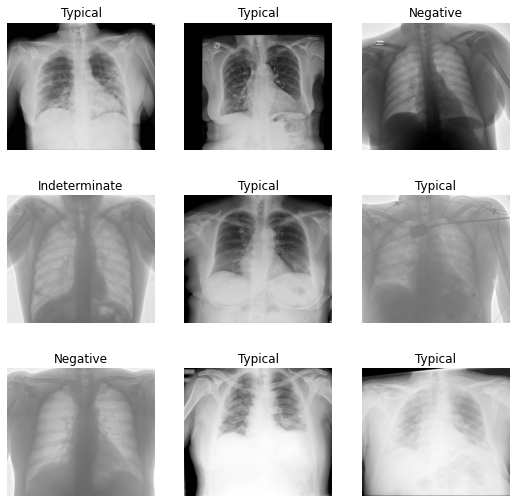

In [11]:
dls. show_batch()

## Create learner

In [18]:
learn = cnn_learner(
    dls, 
    xresnet50,
    metrics = accuracy
)

## Load pretrained weights
These weights come from training on a object detection problem, rather than clasification.

In [30]:
load_model('xres50_bbox_enc.pkl', learn.model[0], opt=None, with_opt=False)

## Frozen / unfrozen training at given size

In [31]:
learn.freeze()

SuggestedLRs(valley=tensor(0.0044))

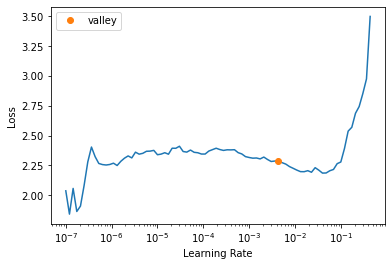

In [26]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(5, lr_max = 6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.257226,1.528353,0.550000,00:32
1,1.286767,1.149945,0.586667,00:32
2,1.218142,1.159250,0.570000,00:32
3,1.001772,1.107529,0.600000,00:32
4,0.832837,1.103893,0.580000,00:32


In [33]:
learn.unfreeze()

SuggestedLRs(valley=tensor(3.0200e-05))

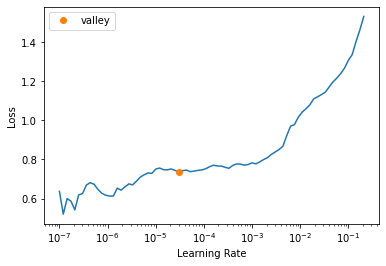

In [34]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(5, lr_max = slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.751042,1.133057,0.580000,00:34
1,0.755484,1.235835,0.556667,00:35
2,0.604856,1.296250,0.570000,00:34
3,0.368040,1.231799,0.576667,00:34
4,0.283573,1.256817,0.570000,00:34


## Save the result
The encoder can be used in training for object detcetion. The learner is used to predict the test images.

In [37]:
encoder = get_model(learn.model)[0]
save_model('xres50_enc.pkl', encoder, opt = None, with_opt=False)
learn.export('classifier_xres50.pkl')

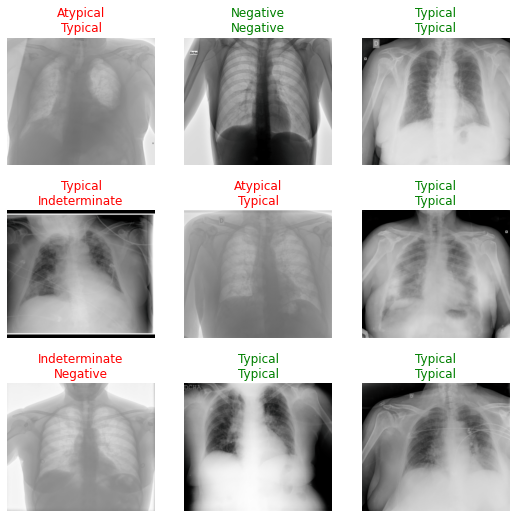

In [38]:
learn.show_results()